In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
import seaborn as sns

# Set black, gray, and white theme
plt.style.use('grayscale')  # Converts plots to grayscale
sns.set_style("darkgrid")  # Apply a dark grid background

In [ ]:
#Load the dataset
data = pd.read_csv('TB Dataset 2024.csv')
data['Months'] = pd.to_datetime(data['Months'], format='%b-%y')
data.set_index('Months', inplace=True)

In [ ]:
# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

In [ ]:
print(train.shape)
print(test.shape)

(72, 1)
(18, 1)


In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Cases']])
train_scaled = scaler.fit_transform(train[['Cases']])
test_scaled = scaler.transform(test[['Cases']])

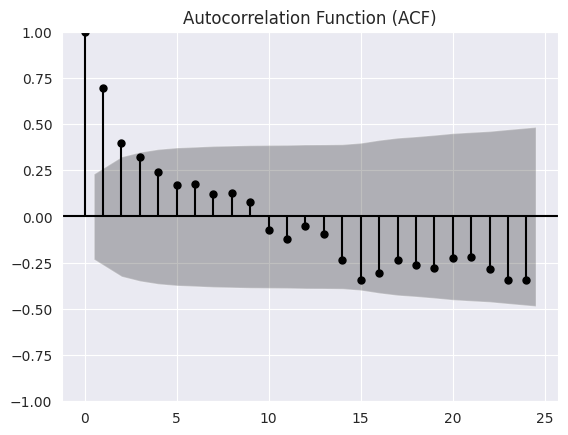

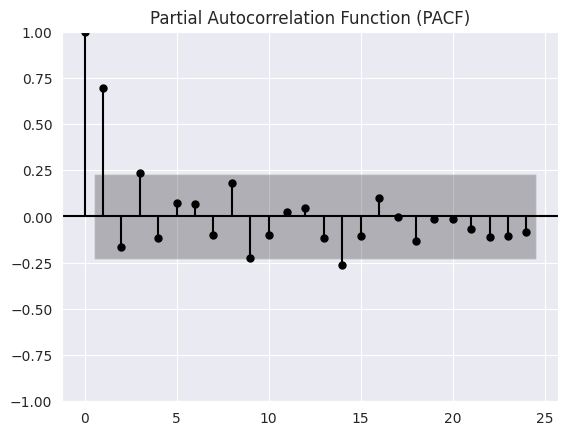

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plot_acf(train['Cases'], lags=24)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plot_pacf(train['Cases'], lags=24)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [ ]:
# Prepare the dataset
def create_nnar_dataset(data, p, P, m):
    X, y = [], []
    for i in range(p + P * m, len(data)):
        # Non-seasonal lags
        non_seasonal = data[i - p:i]
        # Seasonal lags
        seasonal = [data[i - m * j] for j in range(1, P + 1)]
        # Combine non-seasonal and seasonal lags
        X.append(np.concatenate([non_seasonal, np.array(seasonal).flatten()]))
        y.append(data[i])
    return np.array(X), np.array(y)

X, y = create_nnar_dataset(scaled_data.flatten(), p, P, m)

In [ ]:
from sklearn.model_selection import train_test_split
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# Build the NNAR model
#model = Sequential()
#model.add(Dense(k, activation='relu', input_dim=p + P))  # Hidden layer with k neurons
#model.add(Dense(1))  # Output layer
#model.compile(optimizer='adam', loss='mse')

# Build the NNAR model
model = Sequential([
    Dense(k, activation='relu', input_dim=p + P),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model
#nnar_model=model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
nnar_model=model.fit(X_train, y_train, epochs=50, batch_size=min(8, len(X_train)), verbose=1)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4399
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4155
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3926  
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3709 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3492 
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3280 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3063 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2850 
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2645 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2446
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2239  
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2038 
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1859 
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1682 
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1524 
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━

In [ ]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [ ]:
# Inverse transform the predictions to original scale
train_predictions_actual = scaler.inverse_transform(train_predictions)
test_predictions_actual = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
rmse=sqrt(mean_squared_error(y_test_actual, test_predictions_actual))
mae=mean_absolute_error(y_test_actual, test_predictions_actual)
mape=mean_absolute_percentage_error(y_test_actual, test_predictions_actual)
print(f'Test RMSE: {rmse}')
print(f'Test MAE: {mae}')
print(f'Test MAPE: {mape}')

Test RMSE: 41518.55162890952
Test MAE: 35232.57849378058
Test MAPE: 0.16936790765267906


In [ ]:
rmse=sqrt(mean_squared_error(y_train_actual, train_predictions_actual))
mae=mean_absolute_error(y_train_actual, train_predictions_actual)
mape=mean_absolute_percentage_error(y_train_actual, train_predictions_actual)

print(f'Train RMSE: {rmse}')
print(f'Train MAE: {mae}')
print(f'Train MAPE: {mape}')

Train RMSE: 39505.078270951584
Train MAE: 29398.62108911342
Train MAPE: 0.19077765856197984


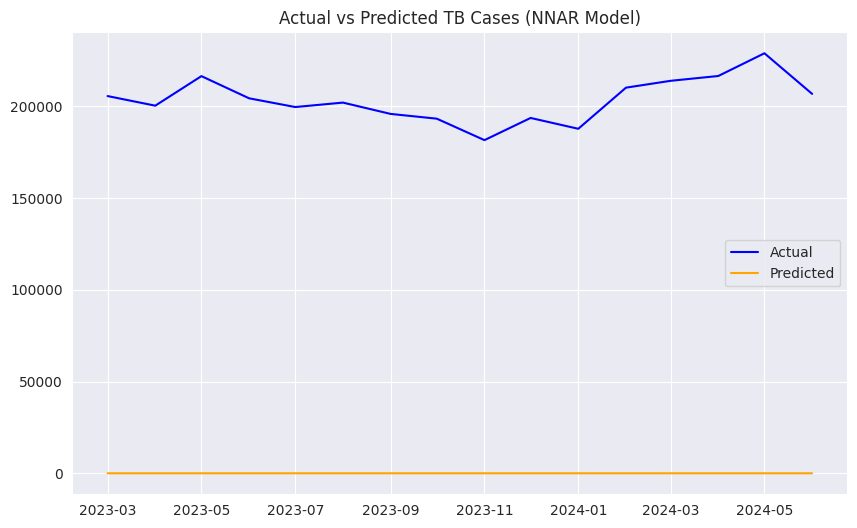

In [ ]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(test.index[-len(y_test_actual):], y_test_actual, label='Actual',color='blue') # Change here to select the last elements of test.index
plt.plot(test.index[-len(test_predictions):], test_predictions, label='Predicted',color='orange') # Change here to select the last elements of test.index that match the length of test_predictions
#plt.plot(test.index[p + m:], y_test_actual, label='Actual')
#plt.plot(test.index[p + m:], test_predictions, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted TB Cases (NNAR Model)')
plt.show()

In [ ]:
!pip install statsmodels

In [ ]:
#Function to create plots with an expanded first graph
import statsmodels.tsa.stattools as sm # Import the statsmodels library with alias sm
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn for distribution plots
import numpy as np
from statsmodels.tsa.stattools import acf


In [ ]:
from datetime import time
residuals=y_test_actual-test_predictions_actual
#time = test.index[p + m:]
time= range(len(residuals))
#time=len(test.index)

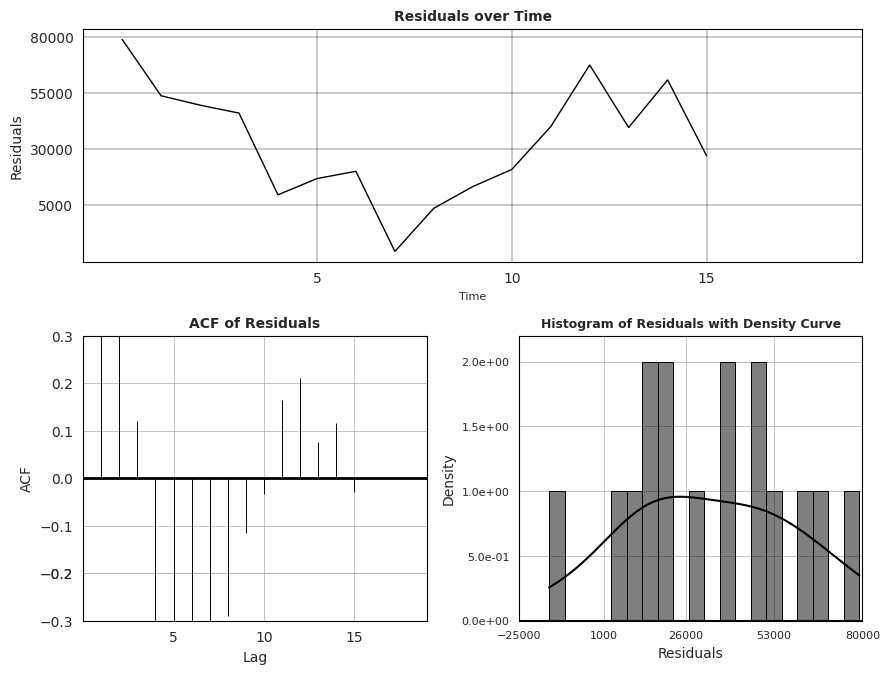

In [ ]:
import matplotlib.ticker as ticker
#Function to create plots with an expanded first graph
def plot_residual_analysis(figsize=(9, 15)):
    fig = plt.figure(figsize=figsize)
    fig.patch.set_facecolor('white')

 # Create grid layout: (3 , 2 columns)
    gs = fig.add_gridspec(3, 2, height_ratios=[9, 11, 11])  # First row larger

    # Residuals over time (spanning both columns in first row)
    ax1 = fig.add_subplot(gs[0, :])  # Spans across both columns
    #ax1.plot(test.index[p + m:], residuals, marker='o', linestyle='dashed', color='gray')
    #time_array = np.arange(len(residuals))
    ax1.plot(time, residuals, color='black', linewidth=1.0)
    ax1.set_facecolor('white')
    ax1.set_title("Residuals over Time", fontsize=10,fontweight='bold')
    ax1.set_xlabel("Time", fontsize=8)
    ax1.set_ylabel("Residuals", fontsize=10)

    # Scale x-axis from 0 to 15 with a step of 5
    #x_tick_range = np.arange(0, 16, 5)  # 0, 5, 10, 15
    #y_tick_range=np.arange(0, 65000,20000)
    #ax1.set_xticks(x_tick_range)
    #ax1.set_yticks(y_tick_range)
    ax1.set_xlim(-1, 19)
    ax1.set_xticks([5,10,15])
    ax1.set_yticks([5000,30000,55000,80000])
    #ax1.set_xlim(-1, 16)  # Ensure the x-axis is correctly limited
    #ax1.set_ylim(-20000, 65000)  # Ensure the y-axis is correctly limited
    #ax1.set_xticklabels(x_tick_range.astype(int))  # Convert to integers
    #ax1.set_yticklabels(y_tick_range.astype(int))
    #ax1.set_yticks(np.arange(0, max(residuals) + 2000, 20000))  # Y-axis in steps of 20000
    ax1.grid(True, linestyle='-', linewidth=0.3, color='black')

    #x_tick_range = np.linspace(0, len(residuals) -1, 5)  # 5 ticks across the range
    #ax1.set_xticks(x_tick_range) # Set x-axis ticks using numerical values
    #ax1.set_xticklabels(x_tick_range.astype(int)) # Format x-axis tick labels as dates
    #ax1.set_yticks(np.arange(0, max(residuals) + 2000, 20000))  # Y-axis in steps of 20000
    #ax1.set_xlim(min(time), max(time))
    #ax1.set_ylim(min(residuals) - 5000, max(residuals) + 5000)
    #ax1.grid(True, linestyle='-', linewidth=0.3, color='darkgray')

    # ACF of Residuals (with larger size and only lines)
    ax2 = fig.add_subplot(gs[1, 0])  # ACF spans across both columns
    lags = np.arange(0, len(residuals))  # Define lags
    acf_values = sm.acf(residuals.squeeze(), nlags=len(residuals) - 1)  # Compute ACF

     # Compute critical values at 95% confidence level
    n = len(residuals)
    conf_interval = 1.96 / np.sqrt(n)
    ax2.vlines(lags[:len(acf_values)], 0, acf_values, color='black', linewidth=0.7)  # ACF vertical lines
    ax2.axhline(0, color='black', linestyle='-', linewidth=2.0)  # Reference line at 0

    #ax2.vlines(lags, 0, acf_values[:15], color='gray', linewidth=0.7)  # ACF vertical lines
    #ax2.axhline(0, color='black', linestyle='-', linewidth=0.5)  # Reference line at 0

    # Add critical value lines (blue, dotted)
    #ax2.axhline(conf_interval, color='blue', linestyle='--', linewidth=0.7)
    #ax2.axhline(-conf_interval, color='blue', linestyle='--', linewidth=0.7)
    ax2.set_xticks([5, 10, 15])

    ax2.set_facecolor('white')
    ax2.set_title("ACF of Residuals",  fontsize=10,fontweight='bold')
    ax2.set_xlabel("Lag", fontsize=10)
    ax2.set_ylabel("ACF", fontsize=10)
    ax2.set_xlim(0, 19)
    ax2.set_xticks([5,10,15])
    ax2.set_ylim(-0.3, 0.3)
    ax2.set_yticks([-0.3,-0.2,-0.2,-0.1,0.0,0.1,0.2,0.3])
    #ax2.set_ylim(-0.50, 0.50)  # Set y-axis limits from -0.50 to 0.50
    #ax2.set_xlim(0, 16)
    ax2.grid(True, linestyle='-', linewidth=0.5,color='darkgray')

    # Histogram with density
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.set_facecolor('white')
    # Plot histogram (gray bars with black edges)
    sns.histplot(residuals, kde=True, bins=20, color='lightgray', edgecolor='black', linewidth=0.7, ax=ax3)

    # Plot KDE (red line)
    sns.kdeplot(residuals, color='black', linewidth=1.5, ax=ax3, fill=False)

    # Set title and labels
    ax3.set_title("Histogram of Residuals with Density Curve", fontsize=9,fontweight='bold')
    ax3.set_xlabel("Residuals", fontsize=10)
    ax3.set_ylabel("Density", fontsize=10)
    ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
    ax3.set_xlim(-25000,80000)
    ax3.set_xticks([-25000,1000,26000,53000,80000])
    ax3.set_ylim(0.0e+00,2.2e+00)
    ax3.set_yticks([0.0e+00,0.5e+00,1.0e+00,1.5e+00,2.0e+00])
    # Set x and y limits
    #ax3.set_xlim(0, 60000)  # X-axis from 0 to 60000
    #ax3.set_ylim(0, 0.000100)

    # Customize grid (light gray, matching the image)
    ax3.grid(True, linestyle='-', linewidth=0.5, color='darkgray')

    # Adjust tick label size
    ax3.tick_params(axis='both', labelsize=8)
    ax3.get_legend().remove()

    # Histogram with density
    #ax3 = fig.add_subplot(gs[1, 1])
    #sns.histplot(residuals, kde=True, ax=ax3, color='gray', bins=20,edgecolor='black',linewidth=0.7)

    # Explicit KDE (red curve)
    #sns.kdeplot(residuals, ax=ax3, color='red', linewidth=1.5, fill=False)

    #ax3.set_facecolor('white')
    #ax3.set_title("Histogram of Residuals with Density Curve", fontsize=8)
    #ax3.set_xlabel("Residuals", fontsize=8)
    #ax3.set_ylabel("Density", fontsize=8)
    #ax3.grid(True, linestyle='-', linewidth=0.3,color='darkgray')
    for ax in [ax1, ax2, ax3]:
        for spine in ax.spines.values():
            spine.set_edgecolor('black')  # Set border color to black
            spine.set_linewidth(0.8)  # Adjust thickness of the border

    # Adjust layout
    plt.tight_layout()
    plt.show()
plot_residual_analysis(figsize=(9, 10))

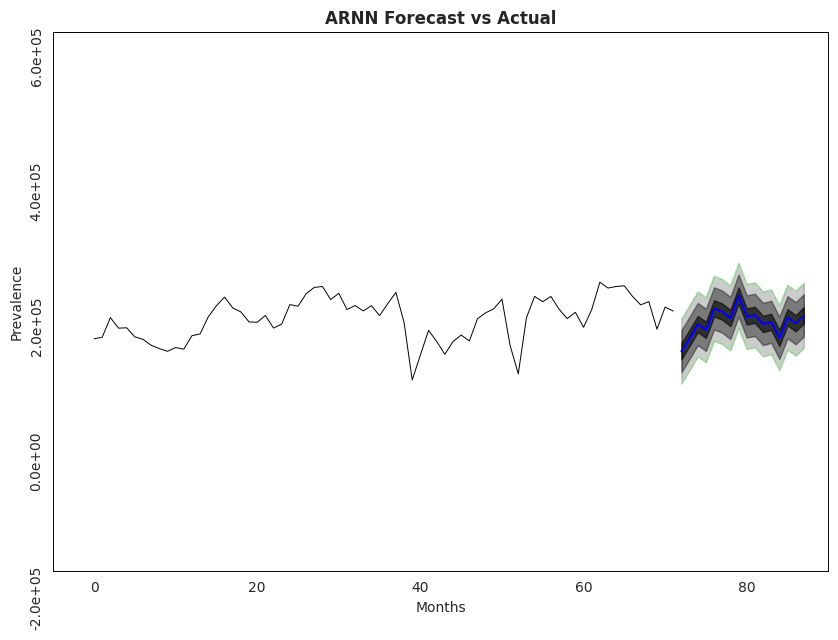

In [ ]:
import matplotlib.ticker as ticker
dates = data.index
# Compute standard deviation for credible interval
forecast_std = np.std(test['Cases'].values - test_predictions_actual) # Convert hybrid_pred to NumPy array
lower_bound = test_predictions_actual.flatten() - 1.96 * forecast_std  # Use .values to get NumPy array and then flatten
upper_bound = test_predictions_actual.flatten() + 1.96 * forecast_std  # Use .values to get NumPy array and then flatten


# Create index-based x-axis
#x_train = np.arange(len(train))  # Training data indices
#x_test = np.arange(len(train), len(train) + len(test))  # Test data indices
x_test = np.arange(len(train), len(train) + len(test_predictions_actual))  # Adjust x_test to match test_predictions


fig, ax = plt.subplots(figsize=(10, 7))  # Set figure size if needed
fig.patch.set_facecolor('white')  # Set figure background to white
ax.set_facecolor('white')  # Set plot area background to white
ax.grid(False)  # Remove grid

# Plot training data
ax.plot(np.arange(len(train)), train['Cases'].values, color='black',linestyle='-', linewidth=0.7, label="Training Data")

# Plot test data and hybrid forecast
ax.plot(x_test, test_predictions_actual, color='blue', label="Hybrid Forecast")

# Plot credible interval
#ax.fill_between(x_test, lower_bound, upper_bound, color='gray', alpha=0.4, label="95% Credible Interval")

# Gradient effect for credible interval
# Create black-to-white gradient credible interval
for alpha, scale in zip([0.6, 0.4, 0.2], [0.5, 1.3, 2.0]):
    ax.fill_between(x_test,
                    test_predictions_actual.flatten() - scale * forecast_std,
                    test_predictions_actual.flatten() + scale * forecast_std,
                    color='black', alpha=alpha)

# Add green dotted boundary lines for the credible interval
ax.plot(x_test, lower_bound, color='lightgreen', linestyle='--', linewidth=1.0, label="Lower Bound")
ax.plot(x_test, upper_bound, color='lightgreen', linestyle='--', linewidth=1.0, label="Upper Bound")

# Set scientific notation on x-axis
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))  # Format as scientific notation (1 decimal)
ax.set_ylim(-2e5, 6e5)
plt.xticks(rotation=360)
plt.yticks(rotation=90)
ax.set_yticks([-2e5, 0, 2e5, 4e5, 6e5])  # Only label these values
ax.tick_params(axis='y', labelsize=10)
ax.set_xlim(-5,90)
for spine in ax.spines.values():
    spine.set_edgecolor('black')  # Set border color to black
    spine.set_linewidth(0.7)
#ax.plot(dates[:train.shape[0]], train['Cases'].values, color='gray',linewidth=0.5, label="Training Data")
#plt.plot(dates[train.shape[0]:], test['Cases'].values, color='green', label="Test Data") # Use train.shape[0] for training data size
#ax.plot(dates[train.shape[0]:], hybrid_pred.values, color='blue', label="Hybrid Forecast") # Convert hybrid_pred to NumPy
#ax.fill_between(dates[train.shape[0]:], lower_bound, upper_bound, color='gray', alpha=0.4, label="95% Credible Interval") # Use train.shape[0] for training data size
ax.set_title("ARNN Forecast vs Actual",fontsize=12,fontweight='bold')
ax.set_xlabel("Months")
ax.set_ylabel("Prevalence")
plt.show()

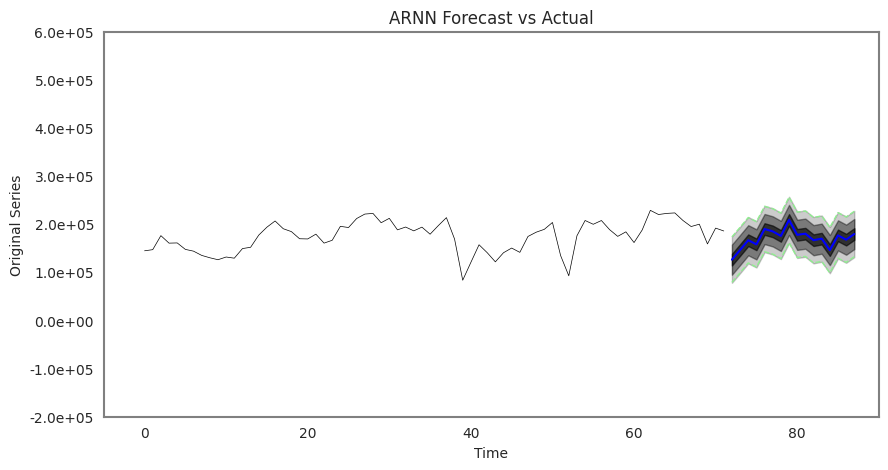

In [ ]:
import matplotlib.ticker as ticker
dates = data.index
# Compute standard deviation for credible interval
#forecast_std = np.std(test['Cases'].values - test_predictions) # Convert hybrid_pred to NumPy array
forecast_std = np.std(test['Cases'].values - test_predictions_actual)
lower_bound =test_predictions_actual.flatten() - 1.96 * forecast_std  # Use .values to get NumPy array and then flatten
upper_bound = test_predictions_actual.flatten() + 1.96 * forecast_std  # Use .values to get NumPy array and then flatten

# Create index-based x-axis
#x_train = np.arange(len(train))  # Training data indices
#x_test = np.arange(len(train), len(train) + len(test))  # Test data indices
x_test = np.arange(len(train), len(train) + len(test_predictions_actual))  # Adjust x_test to match test_predictions


fig, ax = plt.subplots(figsize=(10, 5))  # Set figure size if needed
fig.patch.set_facecolor('white')  # Set figure background to white
ax.set_facecolor('white')  # Set plot area background to white
ax.grid(False)  # Remove grid

# Plot
# Plot training data
ax.plot(np.arange(len(train)), train, color='black', linewidth=0.5, label="Training Data")

# Plot test data and hybrid forecast
ax.plot(x_test, test_predictions_actual, color='blue', label="Hybrid Forecast")

# Plot credible interval
#ax.fill_between(x_test, lower_bound, upper_bound, color='gray', alpha=0.4, label="95% Credible Interval")

# Gradient effect for credible interval
# Create black-to-white gradient credible interval
for alpha, scale in zip([0.6, 0.4, 0.2], [0.5, 1.3, 2.0]):
    ax.fill_between(x_test,
                    test_predictions_actual.flatten() - scale * forecast_std,
                    test_predictions_actual.flatten() + scale * forecast_std,
                    color='black', alpha=alpha)

# Add green dotted boundary lines for the credible interval
ax.plot(x_test, lower_bound, color='lightgreen', linestyle='--', linewidth=1.0, label="Lower Bound")
ax.plot(x_test, upper_bound, color='lightgreen', linestyle='--', linewidth=1.0, label="Upper Bound")

# Set scientific notation on x-axis
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))  # Format as scientific notation (1 decimal)

ax.set_ylim(-2e5, 6e5)
ax.set_xlim(-5,90)
# Add outline (border) on all four sides
for spine in ax.spines.values():
    spine.set_edgecolor('gray')  # Set border color to black
    spine.set_linewidth(1.5)  # Adjust thickness of the border

#ax.plot(dates[:train.shape[0]], train['Cases'].values, color='gray',linewidth=0.5, label="Training Data")
#plt.plot(dates[train.shape[0]:], test['Cases'].values, color='green', label="Test Data") # Use train.shape[0] for training data size
#ax.plot(dates[train.shape[0]:], hybrid_pred.values, color='blue', label="Hybrid Forecast") # Convert hybrid_pred to NumPy
#ax.fill_between(dates[train.shape[0]:], lower_bound, upper_bound, color='gray', alpha=0.4, label="95% Credible Interval") # Use train.shape[0] for training data size
ax.set_title("ARNN Forecast vs Actual")
ax.set_xlabel("Time")
ax.set_ylabel("Original Series")
plt.show()